In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


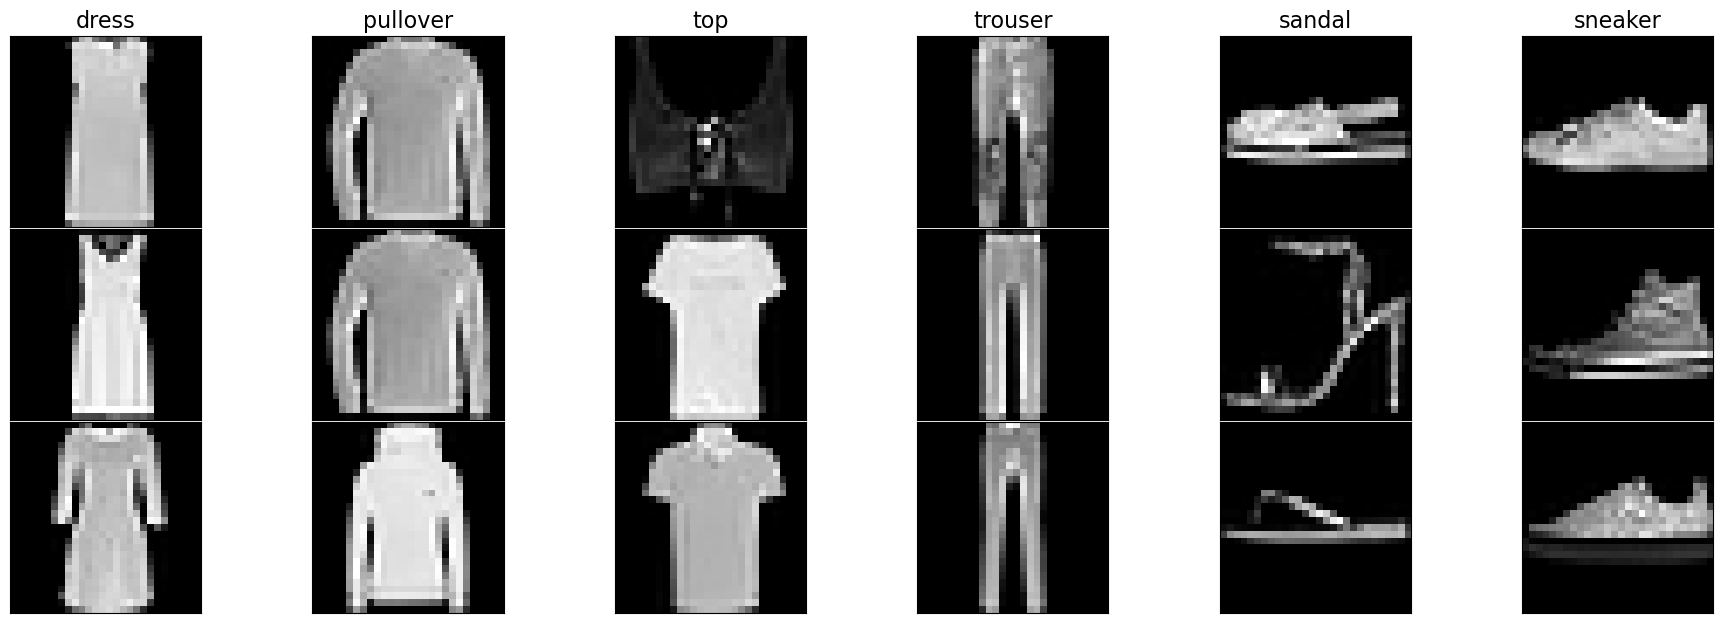

In [2]:
data_dir = os.path.abspath("data_fashion/")

# Load data
train_x = pd.read_csv(os.path.join(data_dir, "x_train.csv")).to_numpy()
train_y_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

valid_x = pd.read_csv(os.path.join(data_dir, "x_valid.csv")).to_numpy()
valid_y_df = pd.read_csv(os.path.join(data_dir, "y_valid.csv"))

# Print shapes
for label, arr in [('train', train_x), ('valid', valid_x)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

# Display via a figure a few examples of each image class

prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();

In [22]:
train_y_df

,class_name,class_uid
0,pullover,2
1,top,0
2,dress,3
3,sandal,5
4,pullover,2
...,...,...
2097,sandal,5
2098,sandal,5
2099,sandal,5
2100,sandal,5


In [23]:
valid_y_df

,class_name,class_uid
0,dress,3
1,dress,3
2,dress,3
3,dress,3
4,dress,3
...,...,...
595,sneaker,7
596,sneaker,7
597,top,0
598,top,0


In [24]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train_x)
normal_train_x = scaler.transform(train_x)

scaler.fit(valid_x)
normal_valid_x = scaler.transform(valid_x)

# Simple Pony

In [27]:
y_train = train_y_df.loc[:,"class_uid"]
y_valid = valid_y_df.values[:,1].copy()
# print(y_train, y_valid)

# y_train = y_train.reshape(-1, 1)
# y_valid = y_valid.reshape(-1, 1)

my_little_pony = MLPClassifier(hidden_layer_sizes=[128],
                               activation='relu',
                               solver='lbfgs',
                               random_state=0)
my_little_pony.fit(normal_train_x, y_train)

MLPClassifier(hidden_layer_sizes=[128], random_state=0, solver='lbfgs')

In [34]:
y_hat = my_little_pony.predict(normal_valid_x)
y_hat = y_hat.reshape(len(y_valid),)

differences = np.abs(y_valid - y_hat)
non_zero_diff_count = np.count_nonzero(differences)
total_elements = len(y_valid)
print(non_zero_diff_count)
print(total_elements)
acc = 1 - (non_zero_diff_count / total_elements)
print("The acc of my little pony is: ")
print(acc)



208
600
The acc of my little pony is: 
0.6533333333333333


In [35]:
def names(case_value):
    switch_dict = {
        1: 'dress',
        2: 'pullover',
        3: 'top',
        4: 'trouser',
        5: 'sandal',
        7: 'sneaker',
        'default': 'null',
    }
    result = switch_dict.get(case_value, switch_dict['default'])
    return result

# Load the dataset of interest
datadir = os.path.abspath('data_fashion')
x_NF = np.loadtxt(
    os.path.join(datadir, 'x_valid.csv'),
    delimiter=',',
    skiprows=1)
N = x_NF.shape[0]

# Create random predictions (just for fun)
predictions = []
for n in range(N):
    result = names(y_hat[n])
    predictions.append(result)

# Save the predictions in the leaderboard format
np.savetxt('yhat_valid.txt', predictions, delimiter='\n', fmt='%s')

In [36]:
datadir = os.path.abspath('data_fashion')

# Load true labels
y_df = pd.read_csv(os.path.join(datadir, 'y_valid.csv'))
ytrue_N = y_df['class_name'].values

# Load predictions
try:
    yhat_N = np.loadtxt('yhat_valid.txt', dtype=str)
except IOError:
    raise ValueError("Did you run save_rand_predictions.py first??")

assert ytrue_N.shape == yhat_N.shape

print("Loaded true and predicted labels")
disp_df = pd.DataFrame(np.hstack([yhat_N[:,np.newaxis], ytrue_N[:,np.newaxis]]),
    columns=['yhat', 'ytrue'])
print(disp_df)

bal_acc = sklearn.metrics.balanced_accuracy_score(ytrue_N, yhat_N)
print("")
print("Balanced Accuracy: %.3f" % bal_acc)
print("remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = %.3f" % (1/6.))

Loaded true and predicted labels
         yhat    ytrue
0         top    dress
1         top    dress
2         top    dress
3         top    dress
4         top    dress
..        ...      ...
595   sneaker  sneaker
596   sneaker  sneaker
597       top      top
598       top      top
599  pullover  trouser

[600 rows x 2 columns]

Balanced Accuracy: 0.615
remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = 0.167


C:\Users\globa\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# New Appempt With CV and Other Hyper Parameters

In [31]:
prng = np.random.RandomState(0)

valid_ids = prng.choice(np.arange(N), size=200)

valid_indicators_N = np.zeros(N)
valid_indicators_N[valid_ids] = -1

my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_N)

my_little_grid = dict(
    hidden_layer_sizes = [(32,)], #[(16,), (32,), (64,)],
    max_iter= [1000], #[64, 128, 1000],
    random_state = [42, 123, 987, 888, 314],
    batch_size= [32], 
    learning_rate_init= [0.001], 
    n_iter_no_change=[10], #[10, 25, 50],
    alpha=[10, 1e0, 1e-1, 1e-2, 1e-3]
    )

my_little_searcher = sklearn.model_selection.GridSearchCV(estimator = my_little_pony,
                                                    param_grid = my_little_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False
                                                   )

my_little_searcher.fit(normal_train_x, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ..., -1, -1])),
             estimator=MLPClassifier(hidden_layer_sizes=[128], random_state=0,
                                     solver='lbfgs'),
             param_grid={'alpha': [10, 1.0, 0.1, 0.01, 0.001],
                         'batch_size': [32], 'hidden_layer_sizes': [(32,)],
                         'learning_rate_init': [0.001], 'max_iter': [1000],
                         'n_iter_no_change': [10],
                         'random_state': [42, 123, 987, 888, 314]},
             refit=False, return_train_score=True, scoring='balanced_accuracy')

In [32]:
my_little_searcher.best_params_

{'alpha': 0.1,
 'batch_size': 32,
 'hidden_layer_sizes': (32,),
 'learning_rate_init': 0.001,
 'max_iter': 1000,
 'n_iter_no_change': 10,
 'random_state': 987}

In [91]:
my_best_pony = MLPClassifier(alpha=0.1,
                             batch_size=32,
                             hidden_layer_sizes=(32,),
                             learning_rate_init=0.001,
                             max_iter=1000,
                             n_iter_no_change=10,
                             random_state=987)
my_best_pony.fit(normal_train_x, y_train)
y_hat = my_best_pony.predict(normal_valid_x)

In [92]:
def names(case_value):
    switch_dict = {
        1: 'dress',
        2: 'pullover',
        3: 'top',
        4: 'trouser',
        5: 'sandal',
        7: 'sneaker',
        'default': 'null',
    }
    result = switch_dict.get(case_value, switch_dict['default'])
    return result

# Load the dataset of interest
datadir = os.path.abspath('data_fashion')
x_NF = np.loadtxt(
    os.path.join(datadir, 'x_valid.csv'),
    delimiter=',',
    skiprows=1)
N = x_NF.shape[0]

# Create random predictions (just for fun)
predictions = []
for n in range(N):
    result = names(y_hat[n])
    predictions.append(result)
# Save the predictions in the leaderboard format
np.savetxt('yhat_valid.txt', predictions, delimiter='\n', fmt='%s')

In [93]:
datadir = os.path.abspath('data_fashion')

# Load true labels
y_df = pd.read_csv(os.path.join(datadir, 'y_valid.csv'))
ytrue_N = y_df['class_name'].values

# Load predictions
try:
    yhat_N = np.loadtxt('yhat_valid.txt', dtype=str)
except IOError:
    raise ValueError("Did you run save_rand_predictions.py first??")

assert ytrue_N.shape == yhat_N.shape

print("Loaded true and predicted labels")
disp_df = pd.DataFrame(np.hstack([yhat_N[:,np.newaxis], ytrue_N[:,np.newaxis]]),
    columns=['yhat', 'ytrue'])
print(disp_df)

bal_acc = sklearn.metrics.balanced_accuracy_score(ytrue_N, yhat_N)
print("")
print("Balanced Accuracy: %.3f" % bal_acc)
print("remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = %.3f" % (1/6.))

Loaded true and predicted labels
        yhat    ytrue
0        top    dress
1        top    dress
2        top    dress
3        top    dress
4        top    dress
..       ...      ...
595  sneaker  sneaker
596  sneaker  sneaker
597      top      top
598      top      top
599      top  trouser

[600 rows x 2 columns]

Balanced Accuracy: 0.610
remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = 0.167


# Attempt 2

In [98]:
valid_indicators_L = np.hstack([
    -1 * np.ones(int(0.8 * y_train.size)), # -1 means never include this example in any test split
    0  * np.ones(y_train.size - int(0.8 * y_train.size)), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

my_little_grid = dict(
    hidden_layer_sizes = [(16,), (32,), (64,)],
    max_iter= [64, 128, 1000],
    random_state = [42, 123, 987, 888, 314],
    batch_size= [32], 
    learning_rate_init= [0.001], 
    n_iter_no_change=[10, 25, 50],
    alpha=[10, 1e0, 1e-1, 1e-2, 1e-3]
    )

my_little_searcher = sklearn.model_selection.GridSearchCV(estimator = my_little_pony,
                                                    param_grid = my_little_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False
                                                   )
my_little_searcher.fit(normal_train_x, y_train)

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

C:\Users\globa\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\globa\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\globa\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\globa\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\globa\a

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPClassifier(hidden_layer_sizes=[128], random_state=0,
                                     solver='lbfgs'),
             param_grid={'alpha': [10, 1.0, 0.1, 0.01, 0.001],
                         'batch_size': [32],
                         'hidden_layer_sizes': [(16,), (32,), (64,)],
                         'learning_rate_init': [0.001],
                         'max_iter': [64, 128, 1000],
                         'n_iter_no_change': [10, 25, 50],
                         'random_state': [42, 123, 987, 888, 314]},
             refit=False, return_train_score=True, scoring='balanced_accuracy')

In [76]:
my_little_searcher.best_params_

{'alpha': 0.01,
 'batch_size': 32,
 'hidden_layer_sizes': (32,),
 'learning_rate_init': 0.001,
 'max_iter': 1000,
 'n_iter_no_change': 10,
 'random_state': 213}

In [95]:
my_best_pony = MLPClassifier(alpha=0.01,
                             hidden_layer_sizes=(32,),
                             batch_size=32,
                             learning_rate_init=0.001,
                             max_iter=1000,
                             activation='relu',
                             solver='sgd',
                             random_state=213,
                             n_iter_no_change=10
                             )

my_best_pony.fit(normal_train_x, y_train)

normed_valid_x = scaler.transform(valid_x)
y_hat = my_best_pony.predict(normed_valid_x)

In [96]:
def names(case_value):
    switch_dict = {
        1: 'dress',
        2: 'pullover',
        3: 'top',
        4: 'trouser',
        5: 'sandal',
        7: 'sneaker',
        'default': 'null',
    }
    result = switch_dict.get(case_value, switch_dict['default'])
    return result

# Load the dataset of interest
datadir = os.path.abspath('data_fashion')
x_NF = np.loadtxt(
    os.path.join(datadir, 'x_valid.csv'),
    delimiter=',',
    skiprows=1)
N = x_NF.shape[0]

# Create random predictions (just for fun)
predictions = []
for n in range(N):
    result = names(y_hat[n])
    predictions.append(result)
# Save the predictions in the leaderboard format
np.savetxt('yhat_valid.txt', predictions, delimiter='\n', fmt='%s')

In [97]:
datadir = os.path.abspath('data_fashion')

# Load true labels
y_df = pd.read_csv(os.path.join(datadir, 'y_valid.csv'))
ytrue_N = y_df['class_name'].values

# Load predictions
try:
    yhat_N = np.loadtxt('yhat_valid.txt', dtype=str)
except IOError:
    raise ValueError("Did you run save_rand_predictions.py first??")

assert ytrue_N.shape == yhat_N.shape

print("Loaded true and predicted labels")
disp_df = pd.DataFrame(np.hstack([yhat_N[:,np.newaxis], ytrue_N[:,np.newaxis]]),
    columns=['yhat', 'ytrue'])
print(disp_df)

bal_acc = sklearn.metrics.balanced_accuracy_score(ytrue_N, yhat_N)
print("")
print("Balanced Accuracy: %.3f" % bal_acc)
print("remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = %.3f" % (1/6.))

Loaded true and predicted labels
         yhat    ytrue
0         top    dress
1         top    dress
2         top    dress
3         top    dress
4         top    dress
..        ...      ...
595   sneaker  sneaker
596   sneaker  sneaker
597       top      top
598       top      top
599  pullover  trouser

[600 rows x 2 columns]

Balanced Accuracy: 0.612
remember, balanced accuracy for a random guess should be (in expectation) 1/C = 1/6 = 0.167


(600,) (600,)


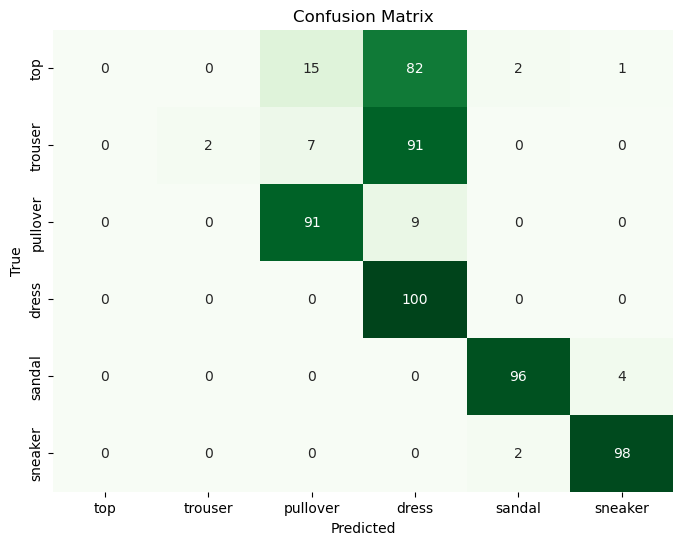

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(y_valid.shape, y_hat.shape)

conf_matrix = confusion_matrix(list(y_valid), list(y_hat))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [85]:
best_mlp_BAcc = balanced_accuracy_score(list(y_valid), list(y_hat))
best_mlp_BAcc

0.645